In [1]:
!pip install tweepy
!pip install vaderSentiment


In [2]:
# Dependencies
import tweepy
import os
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from datetime import datetime


# Import and Initialize Sentiment Analyzer
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
analyzer = SentimentIntensityAnalyzer()
from tweepy import OAuthHandler 


In [3]:
# Twitter API Keys
from config import (consumer_key, 
                    consumer_secret, 
                    access_token, 
                    access_token_secret)

# Setup Tweepy API Authentication
auth = tweepy.OAuthHandler(consumer_key, consumer_secret)
auth.set_access_token(access_token, access_token_secret)
api = tweepy.API(auth, parser=tweepy.parsers.JSONParser())

print(api)

In [4]:
# Target Search Term
target_terms = ("@BBC", "@CBS", "@nytimes",
                "@CNN", "@FoxNews" )

In [5]:
# "Target" Filters
min_tweets = 5
max_tweets = 1000
max_followers = 2500
max_following = 2500

In [6]:
# Create array to hold sentiment
sentiments = []
counter = 1

# Loop through target accounts
for target in target_terms:
    oldest_tweet = None
    compound_list = []
    positive_list = []
    neutral_list = []
    negative_list = []
    
    # Loop through the last 100 tweets by each account
    for loop in range(10):
        public_tweets = api.search(target, count=100, result_type="recent", max_id=oldest_tweet)
        for tweet in public_tweets["statuses"]:
            # Utilize the non-human filters
            if (tweet["user"]["followers_count"] < max_followers and
                tweet["user"]["statuses_count"] > min_tweets and
                tweet["user"]["statuses_count"] < max_tweets and
                tweet["user"]["friends_count"] < max_following):
                
                #Run VADER Analysis on each tweet
                results = analyzer.polarity_scores(tweet["text"])
                compound = results["compound"]
                pos = results["pos"]
                neu = results["neu"]
                neg = results["neg"]
                tweets_ago = counter
                
                # Push to each array
                compound_list.append(compound)
                positive_list.append(pos)
                neutral_list.append(neu)
                negative_list.append(neg)
                
                # Set oldest tweet value
                oldest_tweet = int(tweet["id_str"]) - 1
                
                # Create a sentiments dictionary
                sentiments.append({"User": target,
                                   "Tweet": tweet["text"],
                                   "Date": tweet["created_at"],
                                   "Compound": compound,
                                   "Positive": pos,
                                   "Neutral": neu,
                                   "Negative": neg,
                                   "Tweets Ago": counter})
                # Add to counter
                counter = counter+1
sentiments

[{'User': '@BBC',
  'Tweet': '#ArnabGoswami @AJEnglish #ArnabGoswami @BBCBreaking #ArnabGoswami @republic #ArnabGoswami @sudhirchaudhary… https://t.co/RMODSXLyRx',
  'Date': 'Fri May 22 19:11:19 +0000 2020',
  'Compound': 0.0,
  'Positive': 0.0,
  'Neutral': 1.0,
  'Negative': 0.0,
  'Tweets Ago': 1},
 {'User': '@BBC',
  'Tweet': '@OpenUniversity @Dr_Julie_Smith @BBC A lovely simple message, but is it possible that "toxic productivity" could be… https://t.co/RrwgRBc25D',
  'Date': 'Fri May 22 19:08:18 +0000 2020',
  'Compound': 0.34,
  'Positive': 0.13,
  'Neutral': 0.87,
  'Negative': 0.0,
  'Tweets Ago': 2},
 {'User': '@BBC',
  'Tweet': '@HeatherHarbiso2 @wtvipbsclt @JeffBezos @JSalke @albert_cheng @PrimeVideo @primevideouk @AmazonStudios @RedPlanetTV… https://t.co/ottbFov4OK',
  'Date': 'Fri May 22 19:08:04 +0000 2020',
  'Compound': 0.0,
  'Positive': 0.0,
  'Neutral': 1.0,
  'Negative': 0.0,
  'Tweets Ago': 3},
 {'User': '@BBC',
  'Tweet': '@NevilleSouthall @BBC @M_Star_Online I s

In [7]:
# Convert sentiments to dataframe
sentiments_pd = pd.DataFrame.from_dict(sentiments)
sentiments_pd
# Export & Save Data Into a .csv.
sentiments_pd.to_csv("./output/twitter_sentiment.csv")

In [8]:
bbc_df = sentiments_pd.loc[sentiments_pd['User']=='@BBC', :].reset_index(drop=True).head(100)
cbs_df = sentiments_pd.loc[sentiments_pd['User']=='@CBS', :].reset_index(drop=True).head(100) 
cnn_df = sentiments_pd.loc[sentiments_pd['User']=='@CNN', :].reset_index(drop=True) .head(100)
fox_df = sentiments_pd.loc[sentiments_pd['User']=='@FOXNEWS', :].reset_index(drop=True).head(100) 
nyt_df = sentiments_pd.loc[sentiments_pd['User']=='@NYTIMES', :].reset_index(drop=True).head(100)


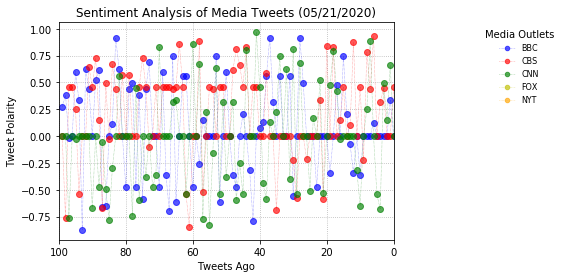

In [9]:
bbc_plt = plt.plot(np.arange(len(bbc_df["Compound"])),bbc_df["Compound"], marker="o", linewidth=0.5,alpha=0.65, color='b', linestyle=':')
cbs_plt = plt.plot(np.arange(len(cbs_df["Compound"])),cbs_df["Compound"], marker="o", linewidth=0.5,alpha=0.65, color='r', linestyle=':')
cnn_plt = plt.plot(np.arange(len(cnn_df["Compound"])),cnn_df["Compound"], marker="o", linewidth=0.5,alpha=0.65, color='g', linestyle=':')
fox_plt = plt.plot(np.arange(len(fox_df["Compound"])),fox_df["Compound"], marker="o", linewidth=0.5,alpha=0.65, color='y', linestyle=':')
nyt_plt = plt.plot(np.arange(len(nyt_df["Compound"])),nyt_df["Compound"], marker="o", linewidth=0.5,alpha=0.65, color='orange', linestyle=':')


plt.grid(linestyle='dotted')
plt.xlim(100,0)
plt.title("Sentiment Analysis of Media Tweets (05/21/2020)")
plt.ylabel("Tweet Polarity")
plt.xlabel("Tweets Ago")
plt.legend(('BBC', 'CBS', 'CNN', 'FOX', 'NYT'),scatterpoints=1,loc='upper left',bbox_to_anchor=(1.25, 1),ncol=1,\
           fontsize=8, markerscale=0.75,title='Media Outlets',edgecolor='none',framealpha=1.00)

plt.savefig("Sentiment_Analysis.png")
plt.show()


In [10]:
# aggregate overall media sentiment for each news outlet
bbc_agg = bbc_df['Compound'].mean()
cbs_agg = cbs_df['Compound'].mean()
cnn_agg = cnn_df['Compound'].mean()
fox_agg = fox_df['Compound'].mean()
nyt_agg = nyt_df['Compound'].mean()

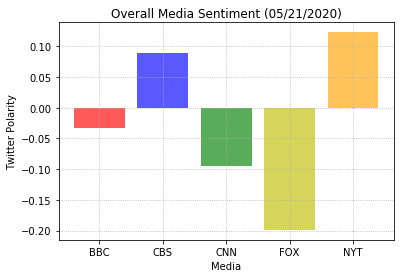

In [13]:
media_agg = ['BBC', 'CBS', 'CNN', 'FOX', 'NYT']
sentiment = [-0.033, 0.090, -0.095, -0.199, 0.123]
x_axis = np.arange(len(sentiment))

colors = ['r', 'b', 'g', 'y', 'orange']

plt.bar(x_axis, sentiment, color=colors, alpha=0.65, align='edge')

tick_locations = [value+0.4 for value in x_axis]
plt.xticks(tick_locations, ["BBC", "CBS", "CNN", "FOX", "NYT"])

plt.grid(linestyle='dotted')
plt.title("Overall Media Sentiment (05/21/2020)")
plt.xlabel("Media")
plt.ylabel("Twitter Polarity")
plt.savefig("Media_Mean_Sentiment.png")
plt.show()
